In [1]:
#################################################################################
# Step 1: Create a table in our database to hold the stock data
#################################################################################

# import some standard modules we can use to download URLs 
import urllib.request
import zipfile, os
import time 
import sqlite3
import datetime
import calendar

                 


In [2]:
conn = sqlite3.connect('example.db')
c = conn.cursor()

# Create table 
c.execute('CREATE TABLE prices (SYMBOL text, SERIES text, OPEN real, HIGH real, LOW real, CLOSE real, LAST real, PREVCLOSE real, TOTTRDQTY real, TOTTRDVAL real, TIMESTAMP date, TOTALTRADES real, ISIN text, PRIMARY KEY (SYMBOL, SERIES, TIMESTAMP))')
conn.commit() 

In [3]:
#################################################################################
# Step 2: Download a bunch of files and unzip them 
#################################################################################


def download(localZipFilePath,urlOfFileName):
    # We already wrote the code for this bit in the drill on files. Lets just copy that over 
    # This bit of boiler plate code below is needed because the 
    # website of the National Stock Exchange tries to block automated 
    # programs (like this one!) from downloading files. 
    # This line is not needed with all websites, but there are a reasonable 
    # number that will block automated downloads, in which case the additional line below
    # will circumvent the block. 
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}

    # here below is the code that actually downloads the page and stores to file

    # Make the web request - just as a web browser like Chrome or Mozilla would
    # Note that we pass in the boilerplate code we just typed above
    webRequest = urllib.request.Request(urlOfFileName, headers=hdr)

    # Doing stuff with files is quite prone to errors in the disk or in the network
    # connection, so use a try:/except: pair as safety net
    try:
        # Make the web request 
        page = urllib.request.urlopen(webRequest)
        # Save the contents of the web request in a variable called 'content'.
        # These contents are literally the zip file from the URL (i.e. what you'd get 
        # if you downloaded the URL manually)
        content = page.read()
        # Save the contents to the zip file on disk locally
        # 1. open the barrel (file). The 'w' signifies that we intend to write, i.e 
        # put stuff into the barrel (file)
        output = open(localZipFilePath, "wb")
        # 2. write contents to file, i.e. actually put stuff in the barrel
        output.write(bytearray(content))
        # 3. close the barrel (i.e. the file)
        output.close()
    # this bit below, the except: block is what will get executed if any of the lines above throw errors
    except(urllib.request.HTTPError, e):
        # print out exactly what error, if any, resulted
        print(e.fp.read())
        # Let the user know that the download did not work, and that file needs to be manually downloaded
        print("Looks like the download did not go through. Please download manually \nFROM:" + urlOfFileName + "\nTO:" + localZipFilePath)
def unzip(localZipFilePath, localExtractFilePath):
    # This bit had also been written earlier. Copying that as well
    # check if the zip file above was downloaded fine, else no point trying to extract
    # note how the os.path.exists gives us a single-line way to check if a given file exists
    if os.path.exists(localZipFilePath):
        # if we are in here (the body of the if-statement), that means the file
        # does indeed exist
        print("Cool! " + localZipFilePath + " exists..proceeding") 
        # A zip file can contain any number of files - we don't know upfront how many
        # so initialize an empty array in which to save the names of the files
        listOfFiles = []
        # Open the barrel (the zip file). The 'rb' is very significant
        #   r: read i.e. we plan to take stuff out of the barrel, not put stuff in
        #   b: binary i.e. the barrel contains stuff that needs processing.
        # That further processing is exactly what the code below will do using the 
        # zipfile library.  
        fh = open(localZipFilePath, 'rb')
        # We've opened the file, now pass it to the library zipfile, which will give 
        # us a variable, here called 'zipFileHandler' which knows exactly what to do 
        # with this file.
        zipFileHandler = zipfile.ZipFile(fh)
        # zipFileHandler knows how to read the list of zipped up files in the zip. 
        # Iterate over them in a for-loop. 'name' is the iterator variable. 
        for name in zipFileHandler.namelist():
            # Extract this particular file, named 'name' to the directory called 'localExtractFilePath'
            zipFileHandler.extract(name, localExtractFilePath)
            # Add this file to the list of files that we are maintaining
            listOfFiles.append(localExtractFilePath + name)
            print("Extracted " + name + " from the zip file, and saved to " + (localExtractFilePath + name))
        # note from the indentation that we are now outside the for loop!
        # lets print the total number of files we extracted from our zip file
        print("Extracted " + str(len(listOfFiles)) + " file in total")
        fh.close()
        
        
def findDate(date):
    day=datetime.datetime.strptime(date,'%d %b %Y').weekday()
    return (calendar.day_name[day])


def downloadAndUnzipForPeriod(listOfMonths, listOfyears):
    for year in listOfYears:
        # indentation changes - we are inside the first for loop ( for the years)
        for month in listOfMonths:
            # indentation changes yet again - we are inside the second for loop ( for each  month in a given year)
            for dayOfMonth in range(31) : 
                date = dayOfMonth + 1 
                # lists are indexed from 0 but the dates start from 1, so add 1 
                ############################################################################
                # OK the code that follows basically constructs a URL for the file 
                # as saved in the NSE website. How do we know how to construct this? 
                # Simply by manually downloading these files and examining the pattern for 
                # different dates/months/years. 
                # A typical URL looks like this : http://www.nseindia.com/content/historical/EQUITIES/2015/JUL/cm07JUL2015bhav.csv.zip
                #############################################################################
                # Convert number to string
                dateStr = str(date)
                # Note how single digit dates have a leading 0 
                if date < 10:
                    # indentation shows we are inside the if condition 
                    dateStr = "0"+dateStr
                    # tack on a leading zero
                # indentation changes - we are out of the if loop 
                print(dateStr, "-", month,"-", year)
                newDate = dateStr + " " + month + " "+ year
                dayOfWeek = findDate(newDate)
                if dayOfWeek == "Monday" or dayOfWeek == "Tuesday" or dayOfWeek == "Wednesday" or dayOfWeek == "Thursday" or dayOfWeek == "Friday":
                    # Construct the filename
                    fileName = "cm" +str(dateStr) + str(month) + str(year) + "bhav.csv.zip"
                    # Construct the entire URL
                    urlOfFileName = "http://archives.nseindia.com/content/historical/EQUITIES/"+ year +"/"+ month + "/" + fileName
                    # Construct the file on our local hard disk where we wish to save the downloaded file
                    # The file path would look different on Windows machines
                    localZipFilePath = "D:\MTU Course Files\SEM 4\CDSS\Assignment 1" + fileName
                    # Make the call to the download function 
                    download(localZipFilePath, urlOfFileName)
                    # MAke the call to the unzip function 
                    unzip(localZipFilePath,localExtractFilePath)
                    # We want to make sure that we don't inadvertently overwhelm the NSE website
                    # so take a pause of 10 seconds to make sure we are not overloading it 
                    time.sleep(10)
                    # done with all 3 for loops , the years, months and days
        print("OK, all done downloading and extracting")
        
        

In [4]:
#initialize a variable with a local directory in which to extract the 
# zip file above
localExtractFilePath = "D:\MTU Course Files\SEM 4\CDSS\Assignment 1"
listOfMonths = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
listOfYears = ['2014']

downloadAndUnzipForPeriod(listOfMonths,listOfYears)

01 - JAN - 2014
Cool! D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm01JAN2014bhav.csv.zip exists..proceeding
Extracted cm01JAN2014bhav.csv from the zip file, and saved to D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm01JAN2014bhav.csv
Extracted 1 file in total
02 - JAN - 2014
Cool! D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm02JAN2014bhav.csv.zip exists..proceeding
Extracted cm02JAN2014bhav.csv from the zip file, and saved to D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm02JAN2014bhav.csv
Extracted 1 file in total
03 - JAN - 2014
Cool! D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm03JAN2014bhav.csv.zip exists..proceeding
Extracted cm03JAN2014bhav.csv from the zip file, and saved to D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm03JAN2014bhav.csv
Extracted 1 file in total
04 - JAN - 2014
05 - JAN - 2014
06 - JAN - 2014
Cool! D:\MTU Course Files\SEM 4\CDSS\Assignment 1cm06JAN2014bhav.csv.zip exists..proceeding
Extracted cm06JAN2014bhav.csv from the zip file, and saved to D:\MTU Course Files\S

NameError: name 'e' is not defined

In [5]:
#####################################################################
# Step 3: parse each file, and insert each row of each file into the database
#####################################################################


def insertRows(fileName,conn):
    # conn is a connection to the database, 
    # given a connection we need a session in which to do stuff
    c = conn.cursor()
    lineNum = 0 
    with open(fileName, 'r') as csvfile:
        # the file is opened now let's get a csv handler. The handler needs to be told how strings in quotes 
        # will appear - we tell it that quotes will be marked by double quotes 
        lineReader = csv.reader(csvfile, delimiter = ',', quotechar = "\"")
        # Ok! the CSV handler called 'lineReader' knows how to read a file 1 line at a time
        # Iterate using a for loop and the iterator variable 'row'
        
        for row in lineReader:
            # what line are we on? Increase the counter by 1
            lineNum = lineNum + 1
            # if this was the first line - which contains a header - skip and 
            # go to the next via the 'continue' statement
            if lineNum ==1:
                print("Header row, skipping")
                continue
            # Insert a row of data 
            date_object = datetime.strptime(row[10], '%d-%b-%Y')
            #############################################################################
            # We just wrote to the database, so we must commit our writes 
            #############################################################################
            # We will insert data into the database 1 row at a time. This data must correspond
            # in the number and type to the column headers of the table. The columns in a table are 
            # collectively called the schema 
            oneTuple = [row[0], row[1], float(row[2]),float(row[3]),float(row[4]),float(row[5]),float(row[6]),float(row[7]),float(row[8]),float(row[9]),date_object,float(row[11]),row[12]]                
            # This statement will actually insert a single row into the table called prices
            c.execute("INSERT INTO prices VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)",oneTuple)
        # As the changed indentation tells us, we are now out of the for - loop, as well as out of the 'with' block. 
        # The magic bit of the 'with...' statement is that the file (barrel) we had opened is closed without our doing 
        # anything explicit
        ##################################################################################
        # We just wrote to the database, so we must commit our writes 
        ###################################################################################
        conn.commit()
        print("Done iterating over file contents - the file has been closed now!")
        

                


In [6]:
# Insert into table 
import os, csv, datetime 
from datetime import datetime 

localExtractFilePath = "D:\MTU Course Files\SEM 4\CDSS\Assignment 1"
# USe a python library to get a list of all files in a particular directory 
for file in os.listdir(localExtractFilePath):
    # as the indentation tells we are in body of the loop 
    # 'file' is the name of the loop variable 
    if file.endswith(".csv"):
        # Yet another indentation change - we are now inside the if condition
        # IF the filename ends with '.csv' its a file we care about - make a function 
        # call to the function above to insert into the database 
        insertRows(localExtractFilePath+"/"+file,conn)

Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over file contents - the file has been closed now!
Header row, skipping
Done iterating over fi

In [7]:
######################################################################
# Step 4: Run a test query against the database to make sure it is set up OK 
######################################################################

t1 = 'ICICIBANK'
series = 'EQ'
c = conn.cursor()
cursor = c.execute ('SELECT symbol, max(close), min(close), max(timestamp), min(timestamp), count(timestamp) FROM prices WHERE symbol = ? and series = ? GROUP BY symbol ORDER BY timestamp', (t1,series))
for row in cursor: 
    print(row)

('ICICIBANK', 1097.7, 958.05, '2014-02-26 00:00:00', '2014-01-01 00:00:00', 41)


In [8]:
##########################################################################
# Step 5: Run a query to get all data for a given stock, and create an excel summary
##########################################################################

import xlsxwriter
# we need xlsxwriter in order to  create excel files


def createExcelWithDailyPriceMoves(ticker,conn):
    # get a cursor from the connection
    # we will use this cursor to execute SQL commands 
    c = conn.cursor()
    # Now execute a query (i.e. read from the database) to get all information for this particular ticker 
    cursor = c.execute('SELECT symbol, timestamp, close FROM prices where symbol = ? and series = ? ORDER BY timestamp',(ticker,series))
    # pay close attention to the way '?' is used - twice - once each as placeholder for the symbol and for the series 
    # This is a standard way of passing inputs to customize queries. Also note the syntax used to pass in the 2 inputs 
    
    
    # import the xlsxwriter which does all the magic 
    # Initialize a variable with the name of the excel file we will create - 
    # this will have the same name as the ticker that we care about 
    excelFileName = "D:\MTU Course Files\SEM 4\CDSS\Assignment 1\Output"+ticker+".xlsx"
    # create a workbook. This in a different way is opening a file 
    workbook = xlsxwriter.Workbook(excelFileName)
    # Create an empty worksheet in this workbook, named 'summary' 
    worksheet = workbook.add_worksheet("Summary")
    # The way we write stuff into this excel workbook is passing 
    # the cell address to start write stuff eg "A1"
    # a list of values that will be written , 1 per cell starting from that address 
    worksheet.write_row("A1",["Top Traded Stocks"])
    worksheet.write_row("A2",['Stock','Date','Closing'])
    lineNum = 3 
    # Everything in life is a list - notice how the results of the query are a list 
    # and we can iterate over this list of results using a for loop 
    for row in cursor: 
        worksheet.write_row("A"+str(lineNum), list(row))
        print("A"+str(lineNum),list(row))
        lineNum = lineNum + 1 
    # Indentation changes - we are done with the for loop that writes the raw data 
    # Ok - all of the code after this is devoted to creating a line chart in excel 
    chart1 = workbook.add_chart({'type':'line'})
    # Configure the first series 
    chart1.add_series({
            'categories': '=Summary!$B$3:$B$' + str(lineNum),
            'values': '=Summary!$C$3:$C$'+str(lineNum)
            # check out this boiler plate code that tells xlsxwriter where to find the data for his chart 
            # We know that we started writing the data in cell B3, and that the last row we filled in 
            # is still stored in the 'lineNum' variable
        })
    # Add a chart title and some axis labels
    chart1.set_title({'name': ticker})
    chart1.set_x_axis({'name':'Date'})
    chart1.set_y_axis({'name': 'Closing Price'})
    
    # Insert the chart into the worksheet (with an offset)
    worksheet.insert_chart('F2',chart1,{'x_offset': 25, 'y_offset': 10})
    workbook.close()
    
    
    
# Create a connection 
conn=sqlite3.connect('example.db')
# Call the function above to create an excel file for the ticker 
# RELIANCE which is one of Indias most actively traded stocks 
createExcelWithDailyPriceMoves('RELIANCE',conn)
# Close the connection. We only queried (read) from the database 
# so there is no need to commit 
 


A3 ['RELIANCE', '2014-01-01 00:00:00', 888.8]
A4 ['RELIANCE', '2014-01-02 00:00:00', 875.0]
A5 ['RELIANCE', '2014-01-03 00:00:00', 864.25]
A6 ['RELIANCE', '2014-01-06 00:00:00', 854.95]
A7 ['RELIANCE', '2014-01-07 00:00:00', 842.1]
A8 ['RELIANCE', '2014-01-08 00:00:00', 849.05]
A9 ['RELIANCE', '2014-01-09 00:00:00', 850.7]
A10 ['RELIANCE', '2014-01-10 00:00:00', 858.15]
A11 ['RELIANCE', '2014-01-13 00:00:00', 880.4]
A12 ['RELIANCE', '2014-01-14 00:00:00', 881.5]
A13 ['RELIANCE', '2014-01-15 00:00:00', 885.45]
A14 ['RELIANCE', '2014-01-16 00:00:00', 886.15]
A15 ['RELIANCE', '2014-01-17 00:00:00', 884.75]
A16 ['RELIANCE', '2014-01-20 00:00:00', 869.75]
A17 ['RELIANCE', '2014-01-21 00:00:00', 863.05]
A18 ['RELIANCE', '2014-01-22 00:00:00', 872.45]
A19 ['RELIANCE', '2014-01-23 00:00:00', 865.8]
A20 ['RELIANCE', '2014-01-24 00:00:00', 867.65]
A21 ['RELIANCE', '2014-01-27 00:00:00', 843.15]
A22 ['RELIANCE', '2014-01-28 00:00:00', 844.85]
A23 ['RELIANCE', '2014-01-29 00:00:00', 836.6]
A24 ['R

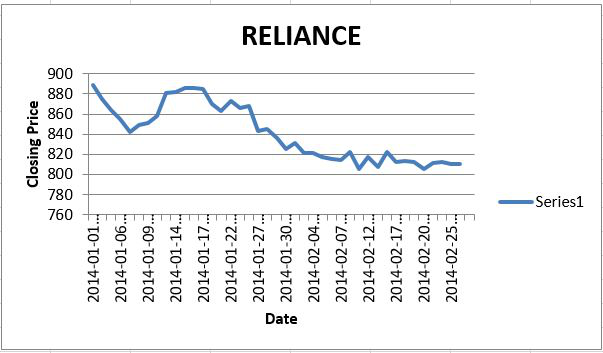

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Image.open("D:\MTU Course Files\SEM 4\CDSS\Assignment 1\output1reliance.JPG")    